<a href="https://colab.research.google.com/github/usshaa/BK_BIRLA_DL/blob/main/08_DL/03_Autoencoder_Implementation_with_Dog_vs_Cat_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Autoencoder

In [1]:
#  Download dataset from Kaggle using curl
!curl -L -o dog-and-cat-classification-dataset.zip \
  https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/dog-and-cat-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  775M  100  775M    0     0  64.6M      0  0:00:11  0:00:11 --:--:-- 52.5M


In [2]:
#  Unzip dataset
!unzip -q dog-and-cat-classification-dataset.zip -d ./data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2

#  Load and preprocess images

In [4]:
IMG_SIZE = 64
DATA_DIR = "./data/PetImages"

In [5]:
cats = []
dogs = []

In [6]:
for img in os.listdir(os.path.join(DATA_DIR, "Cat"))[:5000]:  # limit for speed
    try:
        img_array = cv2.imread(os.path.join(DATA_DIR, "Cat", img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        cats.append(img_array)
    except:
        pass

In [7]:
for img in os.listdir(os.path.join(DATA_DIR, "Dog"))[:5000]:
    try:
        img_array = cv2.imread(os.path.join(DATA_DIR, "Dog", img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        dogs.append(img_array)
    except:
        pass

In [8]:
X = np.array(cats + dogs) / 255.0  # Normalize to [0,1]
print("Dataset shape:", X.shape)

Dataset shape: (10000, 64, 64, 3)


In [9]:
# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

#  Build a Convolutional Autoencoder

In [10]:
def build_autoencoder():
    input_img = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [11]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

#  Train Autoencoder

In [12]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 0.0403 - val_loss: 0.0128
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - loss: 0.0118 - val_loss: 0.0107
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.0095 - val_loss: 0.0085
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - loss: 0.0083 - val_loss: 0.0079
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.0077 - val_loss: 0.0072
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - loss: 0.0070 - val_loss: 0.0065
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0061 - val_loss: 0.0061
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - loss: 0.0061 - val_loss: 0.0066
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - loss: 0.0

#  Visualize Reconstruction

In [13]:
decoded_imgs = autoencoder.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


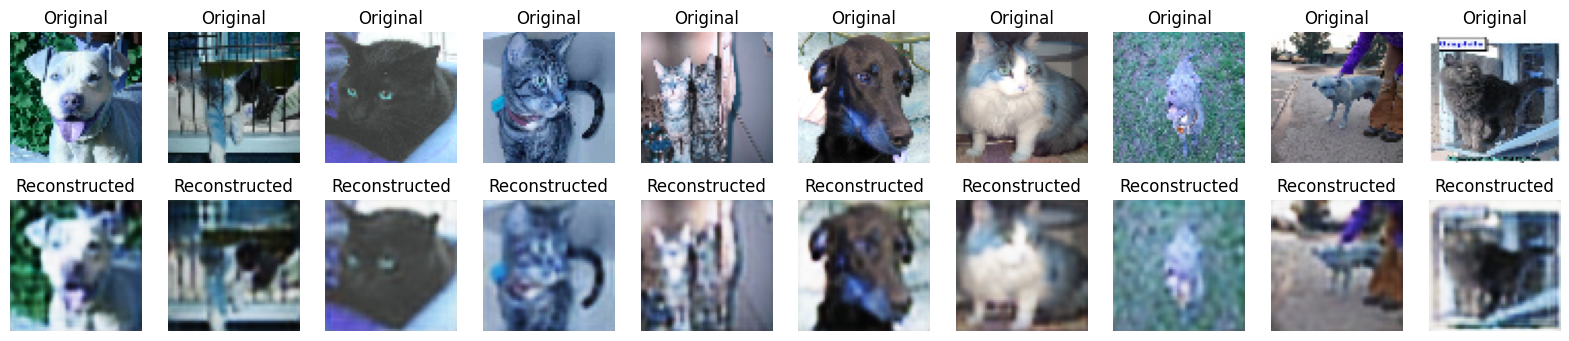

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


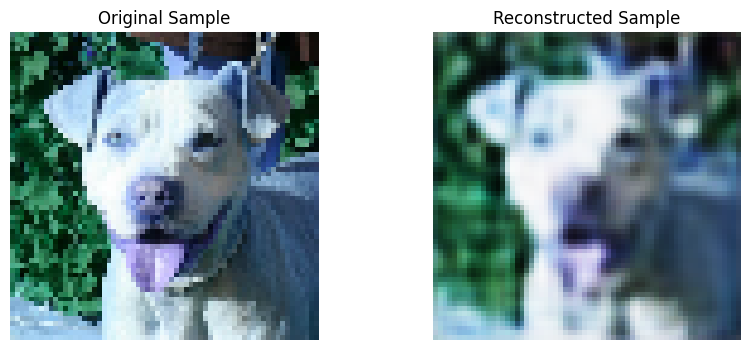

In [16]:
# Save the model in the native Keras format
autoencoder.save('autoencoder_cats_dogs.keras')

# Load the model
loaded_autoencoder = models.load_model('autoencoder_cats_dogs.keras')

# Test with a sample image (using the first image from the test set)
sample_image = X_test[0]
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

decoded_sample = loaded_autoencoder.predict(sample_image)

plt.figure(figsize=(10, 4))

# Original
ax = plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])
plt.title("Original Sample")
plt.axis("off")

# Reconstructed
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_sample[0])
plt.title("Reconstructed Sample")
plt.axis("off")

plt.show()